In [72]:
import numpy as np
import pandas as pd
import seaborn as sns

## Dataset

In [73]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")

In [74]:
df.columns

Index(['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight',
       'acceleration', 'model_year', 'origin', 'fuel_type', 'drivetrain',
       'num_doors', 'fuel_efficiency_mpg'],
      dtype='object')

In [75]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [76]:
columns = [
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg'
]

df = df[columns]

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

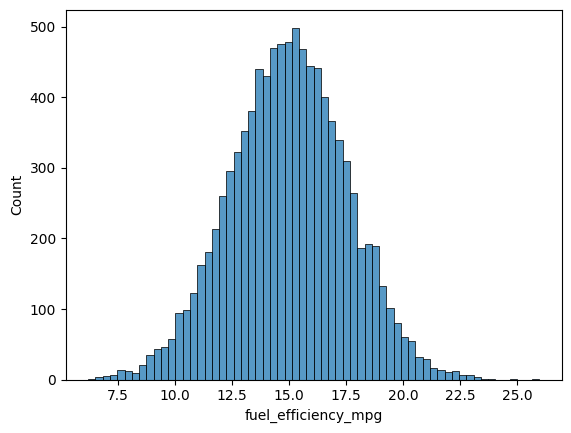

In [77]:
sns.histplot(df['fuel_efficiency_mpg'])

## Question 1
There's one column with missing values. What is it?

In [78]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [79]:
# answer: horsepower

## Question 2
What's the median (50% percentile) for variable 'horsepower'?

In [80]:
df['horsepower'].median()

np.float64(149.0)

In [81]:
# answer: 149

### Prepare train/val/test sets, with 60%/20%/20% distribution

In [82]:
n = len(df)
n_train = int(0.6 * n)
n_val = int(0.2 * n)
n_test = n - n_train - n_val

In [83]:
index = np.arange(n)

In [84]:
np.random.seed(42)
np.random.shuffle(index)

In [85]:
df_shuffled = df.iloc[index]

In [86]:
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val:].copy()

In [87]:
df_train = df_train.reset_index(drop=True)
df_val = df_train.reset_index(drop=True)
df_test = df_train.reset_index(drop=True)

In [88]:
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

In [89]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

## Question 3
Fill missing values with 0 or with the mean of this variable.

For each, train a linear regression model without regularization.

Use the validation dataset to evaluate the models and compare the RMSE of each option.

Round the RMSE scores to 2 decimal digits using round(score, 2)

Which option gives better RMSE?

In [90]:
def linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]
    
def fillna_X(df, fillna_value):
    df = df.fillna(fillna_value)
    X = df.values
    return X

def rmse(y, y_pred):
    error = y_pred - y
    result = np.sqrt((error ** 2).mean())
    return result

In [92]:
X_train = fillna_X(df_train, 0)
w_0, w = linear_regression(X_train, y_train)

X_val = fillna_X(df_val, 0)
y_pred = w_0 + X_val.dot(w)

rmse(y_val,y_pred).round(2)

np.float64(0.5202614265099076)

In [61]:
mean = df_train.horsepower.mean()

X_train = fillna_X(df_train, mean)
w_0, w = linear_regression(X_train, y_train)

X_val = fillna_X(df_val, mean)
y_pred = w_0 + X_val.dot(w)

rmse(y_val, y_pred).round(2)

np.float64(0.47)

In [38]:
# answer: The option with the mean value shows a better RMSE

## Question 4
Regularize the linear regression

In [94]:
def linear_regression_reg (X,y,r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX = r * np.eye(XTX.shape[0]) + XTX
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [99]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = fillna_X(df_train, 0)
    w_0, w = linear_regression_reg (X_train,y_train,r)
    X_val = fillna_X(df_val,0)
    y_pred = w_0 + X_val.dot(w)
    val_rmse = rmse(y_val,y_pred)
    print(f"{r:>6} {val_rmse:>6.2f}")

     0   0.52
  0.01   0.52
   0.1   0.52
     1   0.53
     5   0.53
    10   0.53
   100   0.53


In [100]:
# answer: The option with r=0 shows the smallest RMSE

## Question 5
How does selecting the seed influence our score?

Fill the missing values with 0 and train a model without regularization.

What's the standard deviation of all the scores?

In [101]:
rmse_var = []
seeds = np.arange(10)
for seed in seeds:
    
    n = len(df)
    
    n_train = int(0.6 * n)
    n_val = int(0.2 * n)
    n_train = n - n_test - n_val
    
    index = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(index)
    df_shuffled = df.iloc[index]
    
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val:].copy()
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_train.reset_index(drop=True)
    df_test = df_train.reset_index(drop=True)
    
    y_train = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    y_test = df_test.fuel_efficiency_mpg.values
    
    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']
    
    X_train = fillna_X(df_train, 0)
    w_0, w = linear_regression(X_train, y_train)
    
    X_val = fillna_X(df_val,0)
    y_pred = w_0 + X_val.dot(w)
    
    val_rmse = rmse(y_val,y_pred).round(3)
    rmse_var.append(val_rmse)

overview = np.column_stack([seeds, rmse_var ])
print(overview)

[[0.    0.517]
 [1.    0.515]
 [2.    0.521]
 [3.    0.52 ]
 [4.    0.517]
 [5.    0.52 ]
 [6.    0.512]
 [7.    0.525]
 [8.    0.524]
 [9.    0.522]]


In [102]:
std = np.std(rmse_var)
print(std)

0.0038483762809787747


In [ ]:
# answer: The standard deviation is equal to 0.003

## Question 6
Use seed 9 & fill the missing values with 0 & train a model with r=0.001

What's the RMSE on the test dataset?

In [105]:
seed = 9
r = 0.001
n = len(df)

n_train = int(0.6 * n)
n_val = int(0.2 * n)
n_train = n - n_test - n_val

index = np.arange(n)
np.random.seed(seed)
np.random.shuffle(index)
df_shuffled = df.iloc[index]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val:].copy()

df_train = df_train.reset_index(drop=True)
df_val = df_train.reset_index(drop=True)
df_test = df_train.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

df_train_comb = pd.concat([df_train, df_val])
df_train_comb = df_train_comb.reset_index(drop=True)

X_train_comb = fillna_X(df_train_comb, 0)
y_train_comb = np.concatenate([y_train,y_val])
w_0, w = linear_regression_reg(X_train_comb, y_train_comb,r)

X_test = fillna_X(df_test,0)
y_pred = w_0 + X_test.dot(w)

val_rmse = rmse(y_test,y_pred).round(3)
print(val_rmse)

0.522


In [ ]:
# answer: The RMSE is equal to 0.522